In [43]:
# Spark

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
# Instalat las librerias que usaremos
sc.install_pypi_package("pandas") 
sc.install_pypi_package("matplotlib")
sc.install_pypi_package("seaborn")
sc.install_pypi_package("scikit-learn==0.23.2")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
'SparkSession' object has no attribute 'install_pypi_package'
Traceback (most recent call last):
AttributeError: 'SparkSession' object has no attribute 'install_pypi_package'



In [45]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import ArrayType, BooleanType, LongType, FloatType, IntegerType
from pyspark.sql.functions import lit, udf, struct, countDistinct, collect_list, avg, count, col
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

sc = SparkSession \
        .builder \
        .appName("elt_json") \
        .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
# Loading the Data Set
#df = "s3://iexetec-academics-public/mcdia/cdm/resources/sparkify_event_data.json"
df = "s3://iexe-emr-sparkify/data/sparkify_event_data.json"
df = sc.read.json(df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
# check the structure and column names of the dataset
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

In [49]:
# check the first row to see what the data looks like
df.take(1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042')]

In [50]:
df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+---------+------+-------------+---------+----------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|              artist|      auth|firstName|gender|itemInSession| lastName|    length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent| userId|
+--------------------+----------+---------+------+-------------+---------+----------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|           Popol Vuh| Logged In|    Shlok|     M|          278|  Johnson| 524.32934| paid|Dallas-Fort Worth...|   PUT|NextSong|1533734541000|    22683|Ich mache einen S...|   200|1538352001000|"Mozilla/5.0 (Win...|1749042|
|         Los Bunkers| Logged In|  Vianney|     F|            9|   Miller| 238.39302| paid|San Francisco

In [51]:
# Numero de Filas
print('Numero de filas: ', df.count())

# Numero de Columnas
print('Numero de columnas: ' ,len(df.columns))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Numero de filas:  26259199
Numero de columnas:  18

In [52]:
# Numero de NaNs por columna
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min
from pyspark.sql.functions import max, sum, split, udf, isnan, when, count, countDistinct
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   3|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+

In [53]:
# Numero de Nulos por columna
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+
| artist|auth|firstName|gender|itemInSession|lastName| length|level|location|method|page|registration|sessionId|   song|status| ts|userAgent|userId|
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+
|5408927|   0|   778479|778479|            0|  778479|5408927|    0|  778479|     0|   0|      778479|        0|5408930|     0|  0|   778479|     0|
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+

In [54]:
# Numero de filas sin usuario o id
print('# filas sin id de usuario: ', df.filter(df.userId == "").count())
print('# filas sin id de sesion: ',df.filter(df.sessionId == "").count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# filas sin id de usuario:  0
# filas sin id de sesion:  0

In [55]:
# Utilicemos solo las filas con ids
df = df.where((df.userId != ""))
print('Numero de filas: ', df.count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Numero de filas:  26259199

In [56]:
# Revisemos que tipo de acciones ejecutan los usuarios
df.select("page").dropDuplicates().sort("page").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows

## Time stamps

In [58]:
df.show(2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|     artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent| userId|
+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|  Popol Vuh|Logged In|    Shlok|     M|          278| Johnson|524.32934| paid|Dallas-Fort Worth...|   PUT|NextSong|1533734541000|    22683|Ich mache einen S...|   200|1538352001000|"Mozilla/5.0 (Win...|1749042|
|Los Bunkers|Logged In|  Vianney|     F|            9|  Miller|238.39302| paid|San Francisco-Oak...|   PUT|NextSong|1537500318000|    20836|         MiÃ

In [64]:
from datetime import datetime
from pyspark.sql.functions import udf
    
# Creemos la funcion para cambiar tiempo unix a tiempo humano
unix_ts = udf(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

# Convertir la columna ts
df = df.withColumn("ts_", df.ts/1000)
df = df.withColumn("ts_", unix_ts(df.ts_))


# Convertir la columna registration
# Hay que arreglar los nulos
df = df.withColumn("registration_", df.registration/1000)
#df = df.withColumn("registration_", unix_ts(df.registration_))

df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+---------+------+-------------+---------+----------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+-------------------+-------------+
|              artist|      auth|firstName|gender|itemInSession| lastName|    length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent| userId|                ts_|registration_|
+--------------------+----------+---------+------+-------------+---------+----------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+-------------------+-------------+
|           Popol Vuh| Logged In|    Shlok|     M|          278|  Johnson| 524.32934| paid|Dallas-Fort Worth...|   PUT|NextSong|1533734541000|    22683|Ich mache einen S...|   200|1538352001000|"Mozilla/5.0 (Win...|1749042|201

# Veamos el min y max de fechas

In [66]:
df.select(min("ts_"), max("ts_")).first()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(min(ts_)='2018-10-01 00:00:01', max(ts_)='2018-12-01 00:00:02')

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%local
%matplotlib inline


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
unknown magic command 'local'
UnknownMagic: unknown magic command 'local'



In [72]:
print('Usuarios que cancelan: ', df.select("userId").where(df.page == "Cancellation Confirmation").dropDuplicates().count())
print('Usuarios con downgrade: ', df.select("userId").where(df.page == "Downgrade").dropDuplicates().count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Usuarios que cancelan:  5003
Usuarios con downgrade:  15209

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

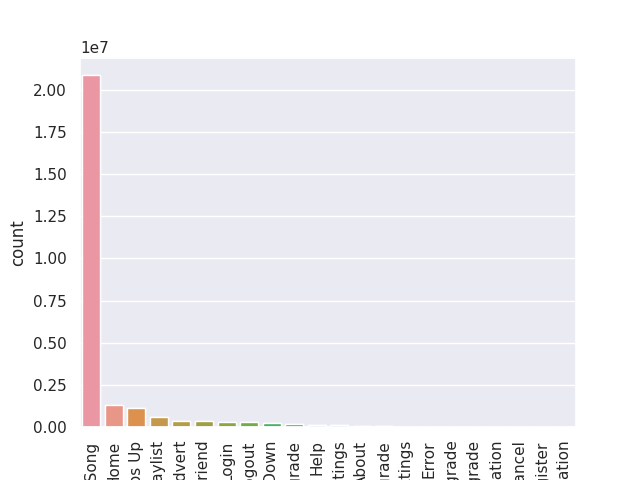

In [76]:
eventos = df.groupby("page").count()
eventos = eventos.sort(desc("count")).toPandas()
g = sns.barplot(data=eventos, x='page', y='count')
plt.xticks(rotation=90)
# Tenemos que agregar esta ultima linea para ver las graficas en EMR
%matplot plt

In [78]:
df.select('page','userId').groupby('page').agg({'page':'count'}).select('page','count(page)').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|           Downgrade|     184240|
|       Save Settings|      29516|
|               Error|      25962|
|     Add to Playlist|     597921|
|                Help|     155100|
|      Submit Upgrade|      15135|
|              Cancel|       5003|
|    Submit Downgrade|       6494|
|         Thumbs Down|     239212|
|                Home|    1343102|
|         Roll Advert|     385212|
|               About|      92759|
|             Upgrade|      50507|
|Cancellation Conf...|       5003|
| Submit Registration|        401|
|               Login|     296350|
|            Register|        802|
|            NextSong|   20850272|
|           Thumbs Up|    1151465|
|              Logout|     296005|
+--------------------+-----------+
only showing top 20 rows

In [79]:
from pyspark.sql.types import IntegerType
# Usuarios que cancelaron su suscripcion. Ahora el segundo argumento de udf
# castea al tipo de dato que especifiquemos. En este caso int.
churn_find = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn", churn_find("page"))
df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+---------+------+-------------+---------+----------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+-------------------+-------------+-----+
|              artist|      auth|firstName|gender|itemInSession| lastName|    length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent| userId|                ts_|registration_|churn|
+--------------------+----------+---------+------+-------------+---------+----------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+-------------------+-------------+-----+
|           Popol Vuh| Logged In|    Shlok|     M|          278|  Johnson| 524.32934| paid|Dallas-Fort Worth...|   PUT|NextSong|1533734541000|    22683|Ich mache einen S...|   200|1538352001000|"Mozilla/5.0 (

In [80]:
gender = df.select('userId', 'gender').dropDuplicates().groupby(['gender']
                                                      ).count().toPandas()

churn_genero = df.where(df.churn == 1).dropDuplicates()
churn_genero = churn_genero.groupby(["gender"]).agg(sum('churn')).toPandas()

churn_genero = gender.merge(churn_genero, on = 'gender')
churn_genero['churn_gender_per'] = churn_genero['sum(churn)']/churn_genero['count']
churn_genero

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  gender  count  sum(churn)  churn_gender_per
0      M  11651        2656          0.227963
1      F  10626        2347          0.220873

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

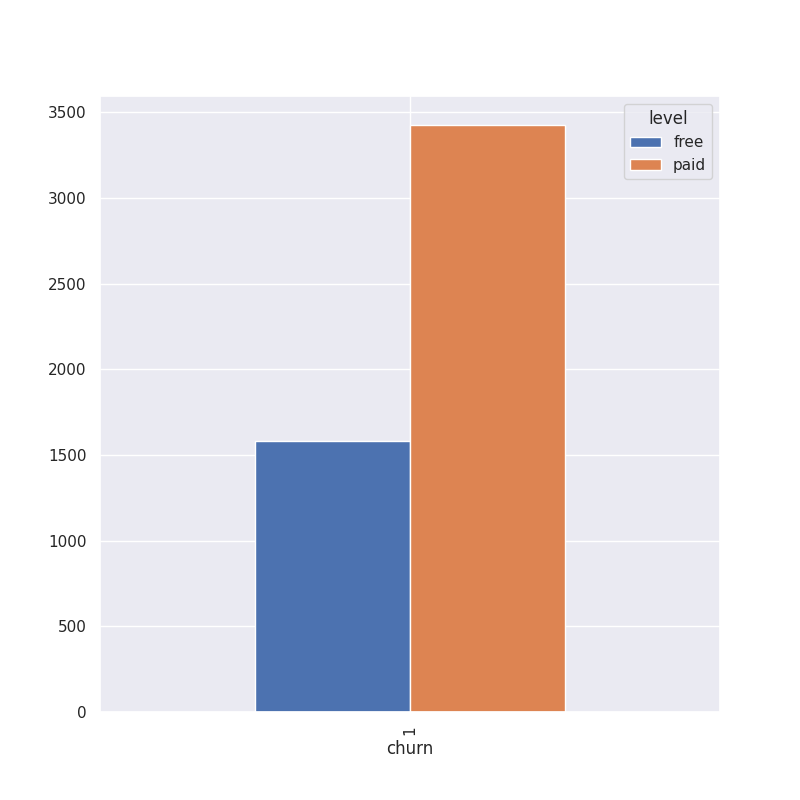

In [81]:
level_churn = df.where(df.churn==1).select('userId','level','churn').groupby('level','churn').count(
    ).toPandas().sort_values(by='count')
print(level_churn)
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
level_churn.pivot(index='churn', columns='level', values='count').plot(kind='bar', ax=ax)
%matplot plt

In [82]:
fe_df = df.select('userId').dropDuplicates()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [83]:
def page_2_var(df, page_cat):
    var_name = (page_cat + '_').lower()
    output = df.filter(df.page == page_cat).groupby('userId') \
                .agg(count('page')).withColumnRenamed('count(page)', var_name)
    # Asegurarnos que la columna que regrese sea numerica
    # Esto nas ayudara mas tarde cuando remplacemos los nulls con cero
    output = output.withColumn(var_name,col(var_name).cast(IntegerType()))
    return output


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [84]:
# Obetener valore sunicos de page en formad de lista
page_values = [cc for c in df.select('page').dropDuplicates().collect() for cc in c]
print(page_values)
# Seleccionemos las varaibles que nos gustaria usar, recuerda que por ahora
# que tenemos un subset de datos

page_fe = ['Add Friend', 'Add to Playlist', 'Thumbs Down',
                           'Thumbs Up', 'Error', 'Settings', 'Upgrade',
           'Help', 'Next Song']

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['Downgrade', 'Save Settings', 'Error', 'Add to Playlist', 'Help', 'Submit Upgrade', 'Cancel', 'Submit Downgrade', 'Thumbs Down', 'Home', 'Roll Advert', 'About', 'Upgrade', 'Cancellation Confirmation', 'Submit Registration', 'Login', 'Register', 'NextSong', 'Thumbs Up', 'Logout', 'Settings', 'Add Friend']

In [85]:
for f in page_fe:
    output = page_2_var(df, f)
    fe_df = fe_df.join(output, 'userId', 'outer')

fe_df = fe_df.na.fill(value=0)
fe_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------+----------------+------------+----------+------+---------+--------+-----+----------+
| userId|add friend_|add to playlist_|thumbs down_|thumbs up_|error_|settings_|upgrade_|help_|next song_|
+-------+-----------+----------------+------------+----------+------+---------+--------+-----+----------+
|1001393|         11|              18|           6|        43|     1|        8|       1|    6|         0|
|1002143|         14|              10|           5|        24|     0|        4|       3|    4|         0|
|1002493|          6|              12|           8|        16|     0|        3|       1|    5|         0|
|1002749|         27|              35|          18|        59|     0|        4|       1|    3|         0|
|1004060|         54|              75|          30|       119|     3|       22|       3|   22|         0|
|1004316|         18|              29|          11|        40|     2|        6|       4|    7|         0|
|1006033|         19|              20|        

In [86]:
from operator import add
from functools import reduce
# Iteremos solo sobre las variables que definimos arriba
page_cols_ = [(c + '_').lower() for c in page_fe if c!='userId']
fe_df = fe_df.withColumn('acciones_totales', reduce(add, [fe_df[col] 
                                                for col in page_cols_]))

fe_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------+----------------+------------+----------+------+---------+--------+-----+----------+----------------+
| userId|add friend_|add to playlist_|thumbs down_|thumbs up_|error_|settings_|upgrade_|help_|next song_|acciones_totales|
+-------+-----------+----------------+------------+----------+------+---------+--------+-----+----------+----------------+
|1001393|         11|              18|           6|        43|     1|        8|       1|    6|         0|              94|
|1002143|         14|              10|           5|        24|     0|        4|       3|    4|         0|              64|
|1002493|          6|              12|           8|        16|     0|        3|       1|    5|         0|              51|
|1002749|         27|              35|          18|        59|     0|        4|       1|    3|         0|             147|
|1004060|         54|              75|          30|       119|     3|       22|       3|   22|         0|             328|
|1004316|       

In [87]:
# Agregar genero 1 si es mujer, 0 si es hombre
gender_fe = udf(lambda x: 1 if x == 'F' else 0, IntegerType())
df = df.withColumn('gender_', gender_fe(df.gender))
gender_df = df.select('userId','gender_').dropDuplicates()
fe_df = fe_df.join(gender_df, 'userId', 'outer')
fe_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------+----------------+------------+----------+------+---------+--------+-----+----------+----------------+-------+
| userId|add friend_|add to playlist_|thumbs down_|thumbs up_|error_|settings_|upgrade_|help_|next song_|acciones_totales|gender_|
+-------+-----------+----------------+------------+----------+------+---------+--------+-----+----------+----------------+-------+
|1001393|         11|              18|           6|        43|     1|        8|       1|    6|         0|              94|      0|
|1002143|         14|              10|           5|        24|     0|        4|       3|    4|         0|              64|      0|
|1002493|          6|              12|           8|        16|     0|        3|       1|    5|         0|              51|      0|
|1002749|         27|              35|          18|        59|     0|        4|       1|    3|         0|             147|      0|
|1004060|         54|              75|          30|       119|     3|       22|    

In [88]:
# Obtengamos los usuarios que cancelaron su suscripcion
churn_df = df.select('userId', 'churn').where(df.churn==1)

# Unamoslo con nuestros datos. Aquellos que tengan valor de null
# En la columna de churn no cancelaron.
fe_df = fe_df.join(churn_df, 'userId', 'outer').na.fill(value=0)
fe_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------+----------------+------------+----------+------+---------+--------+-----+----------+----------------+-------+-----+
| userId|add friend_|add to playlist_|thumbs down_|thumbs up_|error_|settings_|upgrade_|help_|next song_|acciones_totales|gender_|churn|
+-------+-----------+----------------+------------+----------+------+---------+--------+-----+----------+----------------+-------+-----+
|1001393|         11|              18|           6|        43|     1|        8|       1|    6|         0|              94|      0|    0|
|1002143|         14|              10|           5|        24|     0|        4|       3|    4|         0|              64|      0|    0|
|1002493|          6|              12|           8|        16|     0|        3|       1|    5|         0|              51|      0|    1|
|1002749|         27|              35|          18|        59|     0|        4|       1|    3|         0|             147|      0|    0|
|1004060|         54|              75|   

In [92]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
cor_columns = [c for c in fe_df.columns if c!='userId']
assembler = VectorAssembler(inputCols=cor_columns, outputCol=vector_col)
df_vector = assembler.transform(fe_df).select(vector_col)

# Matriz de Correlaciones
matrix = Correlation.corr(df_vector, vector_col)

# Matriz de correlaciones a numpy para visualizarla
import numpy as np 
cor = matrix.collect()[0]["pearson({})".format(vector_col)].values
cor_df = cor.reshape((len(cor_columns),len(cor_columns)))

# A pandas para hacerla legible
pd.set_option('display.max_rows', 15)
cor_df = pd.DataFrame(cor_df, columns=cor_columns)
cor_df['var'] = cor_columns
cor_df.set_index('var')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
name 'pandas' is not defined
Traceback (most recent call last):
NameError: name 'pandas' is not defined



In [90]:
# Importemos lo que usaremos en esta seccion
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [91]:
# Seleccionemos las variables que utilizaremos
variables = [v for v in fe_df.columns if (v !='userId') & (v != 'churn')]
print(variables)

# Concat en un vector con nombre all_features
assembler = VectorAssembler(inputCols = variables, outputCol = 'all_features')
model_df = assembler.transform(fe_df)
model_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['add friend_', 'add to playlist_', 'thumbs down_', 'thumbs up_', 'error_', 'settings_', 'upgrade_', 'help_', 'next song_', 'acciones_totales', 'gender_']
+-------+-----------+----------------+------------+----------+------+---------+--------+-----+----------+----------------+-------+-----+--------------------+
| userId|add friend_|add to playlist_|thumbs down_|thumbs up_|error_|settings_|upgrade_|help_|next song_|acciones_totales|gender_|churn|        all_features|
+-------+-----------+----------------+------------+----------+------+---------+--------+-----+----------+----------------+-------+-----+--------------------+
|1001393|         11|              18|           6|        43|     1|        8|       1|    6|         0|              94|      0|    0|[11.0,18.0,6.0,43...|
|1002143|         14|              10|           5|        24|     0|        4|       3|    4|         0|              64|      0|    0|[14.0,10.0,5.0,24...|
|1002493|          6|              12|           8|    

In [93]:
# Creemos nuestra matriz de modelaje
model_df = model_df.select(model_df['all_features'].alias("features"),
                            model_df['churn'].alias("label"))
model_df.show(3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[11.0,18.0,6.0,43...|    0|
|[14.0,10.0,5.0,24...|    0|
|[6.0,12.0,8.0,16....|    1|
+--------------------+-----+
only showing top 3 rows

In [94]:
# Dividamos en train test
train, test = model_df.randomSplit([0.8, 0.2], seed=568)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [95]:
# Evaluador f1
f1_evaluator = MulticlassClassificationEvaluator(metricName = 'f1')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [96]:
# Definamos el modelo
lr = LogisticRegression(elasticNetParam=0)

# BUsqueda en grid
paramGrid_lr = ParamGridBuilder() \
            .addGrid(lr.regParam, [0.0, 0.1]) \
            .addGrid(lr.maxIter, [10, 50]) \
            .build()


# Define cross-validation
crossval_lr = CrossValidator(estimator = lr,
                          estimatorParamMaps = paramGrid_lr,
                          evaluator = f1_evaluator,
                          numFolds =3)

# Entrenar modelo
lr_model = crossval_lr.fit(train)

# Hacer predicciones
lr_preds = lr_model.transform(test)

# F1
lr_f1_score = f1_evaluator.evaluate(lr_preds)
print('Logistic Regression F1-Score: {}'.format(round(lr_f1_score*100,2)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Logistic Regression F1-Score: 68.83